In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import cv2 as cv
from os import listdir
from os.path import isfile, join
import os
from PIL import Image
import skimage.measure as ip
import urllib3
import h5py
import random
from PIL import Image
import math
from PIL import ImageOps
import keras as kr
import tensorflow as tf
from numba import jit, autojit

os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

Using TensorFlow backend.


In [2]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            images.append(img)
    return images

def plot_I(I, fig=0, res=300, color_map=None):
    if fig:
        plt.figure(dpi=res)
    plt.imshow(I, cmap=color_map)

## load images

In [3]:
folder = r'C:\Users\alexa\OneDrive\00. RESEARCH\01. carpal instability project\code\all_imgs\imgs_test1'
classes = ['abnormal', 'normal']

imgs = {}
for folders in classes:
    folder_final = folder + '\\' + folders
    imgs[folders] = load_images_from_folder(folder_final)

## sampling the normal images
    balancing the dataset (foor normal/abnormal) - making them have the same amount of elements

## data augmentation
    1. original
    2. rotated 0-90 deg
    3. rotated 0-90 deg + flipped vertically
    4. rotated 0-90 deg + flipped horizontally
    5. rotated 0-90 deg + flipped horizontally + flipped vertically
Artificial intelligence in fracture detection: transfer learning from deep convolutional neural networks:
    -180 degrees flip (2x)
    -random rotation 0-25 degrees 
    -width and height shift by a factor of 0%-15%
    -shearing 0-10% 
    -zoom between 0-15%.

In [4]:
@jit(nopython=True, parallel=True)
def generate_random_angle():
    random_no = np.random.rand(1)[0]
    PI_OVER_TWO = math.pi/2
    PI_OVER_TWO_DEG = (math.pi/2)
    return (PI_OVER_TWO*random_no, 90*random_no)

# @jit(nopython=True, parallel=True)
def gen_4_random_rot(I, image_size=299):
    images = []
    Im = Image.fromarray(I)
    image_size = (image_size, image_size)
    
    for i in range(5):
        new_angle = int(generate_random_angle()[1])
        dummy = Im.rotate(new_angle)
        if i==1:
            dummy = ImageOps.mirror(dummy)
        elif i==2:
            dummy = ImageOps.flip(dummy)
        elif i==3:
            dummy = ImageOps.mirror(dummy)
            dummy = ImageOps.flip(dummy)
        elif i==4:
            dummy = Image.fromarray(I)
        
        
        images.append(np.array(dummy.resize(image_size)))
#     images.append(np.array(Im.resize(image_size)))
    return images

# @jit(nopython=True, parallel=False)
def extend_and_shuffle_dataset(X):
    images = []
    for i in range(len(X)):
        images.extend(gen_4_random_rot(X[i]))
    
    shuffled_images = random.sample(images, len(images))
    del images
    return shuffled_images

## processing normal & abnormal
    
    shuffling them and getting 4 random rotations out of them
    normal_samples, abnormal_samples : shuffled versions of the dataset

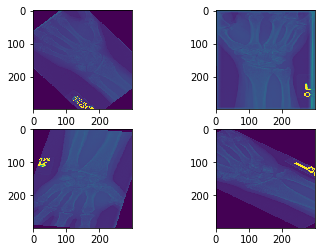

In [5]:
# normal_images = []
# for i in range(len(imgs['normal'])):
#     normal_images.extend(gen_4_random_rot(imgs['normal'][i]))
# normal_samples = random.sample(normal_images, len(normal_images))

suffled_normal_imgs = extend_and_shuffle_dataset(imgs['normal'])
suffled_abnormal_imgs = extend_and_shuffle_dataset(imgs['abnormal'])

if len(suffled_normal_imgs) >= len(suffled_abnormal_imgs):
    len_smallest_dataset = len(suffled_abnormal_imgs)
    suffled_normal_imgs = random.sample(suffled_normal_imgs, len_smallest_dataset)
else:
    len_smallest_dataset = len(suffled_normal_imgs)
    suffled_abnormal_imgs = random.sample(suffled_abnormal_imgs, len_smallest_dataset)
    


for i in range(4):
    plt.subplot(221 + i)
    plt.imshow(suffled_normal_imgs[i])

In [6]:
# del abnormal_images, normal_images
# @jit
def gray_to_rgb(X):
    for i in range(len(X)):
        X[i] = cv.cvtColor(X[i], cv.COLOR_GRAY2RGB)
        
    return X

## building labels and total dataset

In [7]:
L = len_smallest_dataset

X = suffled_normal_imgs + suffled_abnormal_imgs
# X = np.empty(shape=(2*L,1))

X = gray_to_rgb(X)
##adds 3 channels to pic
# for i in range(len(X)):
#     X[i] = cv.cvtColor(X[i], cv.COLOR_GRAY2RGB)

T = np.concatenate((np.zeros((L,1)), np.ones((L,1)))) # NORMAL == 0, ABNORMAL == 1

In [8]:
X = (np.asarray(X, dtype=np.float32)/255).astype(np.float16)
# X = (np.asarray(X, dtype=np.float32)/255)

In [9]:
no_classes = 2
no_samples_train = int(len(X)*.95)
indeces = np.random.permutation(X.shape[0])
idx_train, idx_test = indeces[:no_samples_train], indeces[no_samples_train:]
#samples
X_train = X[idx_train]
X_test = X[idx_test]
#targets
t_train = kr.utils.np_utils.to_categorical(T[idx_train], no_classes)
t_test = kr.utils.np_utils.to_categorical(T[idx_test], no_classes)

In [10]:
# len(X_test) + len(X_train) == len(X)
del X
del T
# indeces[:no_samples_train]

## preparing xception for transfer learning 

In [11]:
net = kr.applications.xception.Xception(include_top=True,\
                                              weights='imagenet', input_tensor=None,\
                                              input_shape=None, pooling=None, classes=1000)
net.layers.pop()

# net.summary()

for lr in range(len(net.layers)):
    net.layers[lr].trainable = False
net.layers[1].trainable = True
net.layers[-1].trainable = True

##adding retrainable layer to the NN\
net_output = net.output
net_output = kr.layers.Activation('relu')(net_output)
net_output = kr.layers.Dropout(0.5)(net_output)

net_output = kr.layers.Dense(500)(net_output)
net_output = kr.layers.Activation('relu')(net_output)
net_output = kr.layers.Dropout(0.5)(net_output)

net_output = kr.layers.Dense(no_classes)(net_output)

net_output = kr.layers.Activation('softmax')(net_output)

W0912 00:36:30.034362  8896 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0912 00:36:30.059368  8896 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0912 00:36:30.064369  8896 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0912 00:36:30.087374  8896 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0912 00:36:30.089375  8896 deprecation_wrapper.py:119] 

In [12]:
# Creating new model. Please note that this is NOT a Sequential() model.
from keras.models import Model
xcustom_net = Model(input=net.input, output=net_output)
xcustom_net.layers[-2].trainable = True
xcustom_net.layers[-5].trainable = True
xcustom_net.layers[-9].trainable = False
xcustom_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
import keras
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Input, Activation, \
                    Dropout, Flatten, Conv2D, MaxPooling2D

from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D,Conv2D, MaxPooling2D, ZeroPadding2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.datasets import cifar10
from keras import backend as K
from keras import regularizers
from keras import optimizers
from keras.layers.core import Lambda

In [14]:
def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))

reduce_lr = kr.callbacks.LearningRateScheduler(lr_scheduler)

In [15]:
datagen = ImageDataGenerator(
#     rescale = 1/255,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=True,  # divide each input by its std
    zca_whitening=False)  # apply ZCA whitening
#     rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
#     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#     horizontal_flip=True,  # randomly flip images
#     vertical_flip=False)  # randomly flip images
# (std, mean, and principal components if ZCA whitening is applied).

C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:355: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


### parameters for CNN

In [ ]:
# batch_size = 32
no_classes = 2
X_shape = [299, 299,3]

learning_rate = 1e-1
lr_decay = 1e-5
lr_drop = 40
# maxepochs = 3
# tf.compat.v1.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)

sgd = SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
xcustom_net.compile(loss='binary_crossentropy',\
              optimizer=sgd, metrics=['accuracy'])

epochs_xray = 20
batch_size = 32
# xcustom_net.summary()

## NN evaluation before run
# print('performance before retraining for train set')
# scores = xcustom_net.evaluate(X_train, t_train, verbose=1)
# print("Accuracy: %.2f%%" % (scores[1]*100))
# print('performance before retraining for test set')
# scores = xcustom_net.evaluate(X_test, t_test, verbose=1)
# print("Accuracy: %.2f%%" % (scores[1]*100))

# for i in range(len(VGG_NN.layers)):
#     VGG_NN.layers[i].trainable = False
#############################################################################################################
# NN run
cnn = xcustom_net.fit_generator(datagen.flow(X_train, t_train,\
                                        batch_size=batch_size),\
                           steps_per_epoch=X_train.shape[0] // batch_size,\
#                            epochs=epochs_xray,\
                           epochs=epochs_xray, validation_data=(X_test, t_test),\
                           callbacks=[reduce_lr], verbose=1)

W0912 00:36:37.296650  8896 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0912 00:36:37.312654  8896 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
487/487 [==============================] - 144s 296ms/step - loss: 0.6859 - acc: 0.5233 - val_loss: 0.6602 - val_acc: 0.5810
Epoch 2/20
487/487 [==============================] - 137s 282ms/step - loss: 0.6288 - acc: 0.6145 - val_loss: 0.6437 - val_acc: 0.6456
Epoch 3/20
487/487 [==============================] - 136s 279ms/step - loss: 0.6090 - acc: 0.6386 - val_loss: 0.6704 - val_acc: 0.5408
Epoch 4/20
487/487 [==============================] - 135s 278ms/step - loss: 0.6099 - acc: 0.6280 - val_loss: 0.6114 - val_acc: 0.7101
Epoch 5/20
487/487 [==============================] - 138s 284ms/step - loss: 0.6044 - acc: 0.6248 - val_loss: 0.6541 - val_acc: 0.6078
Epoch 6/20
487/487 [==============================] - 138s 282ms/step - loss: 0.6079 - acc: 0.6215 - val_loss: 0.6333 - val_acc: 0.6236
Epoch 7/20
487/487 [==============================] - 136s 280ms/step - loss: 0.6078 - acc: 0.6425 - val_loss: 0.6555 - val_acc: 0.6151
Epoch 8/20
487/487 [============================

In [ ]:
# as_net.save_weights('transfer_cifar10alexSnet83.h5')
# as_net.save('alexSnet.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

plt.figure(0)
plt.plot(cnn.history['acc'],'r')
plt.plot(cnn.history['val_acc'],'g')
plt.xticks(np.arange(0, 10, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(cnn.history['loss'],'r')
plt.plot(cnn.history['val_loss'],'g')
plt.xticks(np.arange(0, 10, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()


In [ ]:
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

In [ ]:
dir(cnn)

In [ ]:
len(suffled_abnormal_imgs)

In [ ]:
scores = xcustom_net.evaluate(X_test, t_test, verbose=1)

print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
xcustom_net.save('xcustom_net.h5')

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder, filename))
        images.append(img)
    return images

In [ ]:
folder = r'C:\Users\alexa\OneDrive\00. RESEARCH\01. carpal instability project\code\all_imgs\perilunate_instability'
I_carp = load_images_from_folder(folder)
#     Imgs_all[sheet] = Imgs

In [ ]:
X_carp = extend_and_shuffle_dataset(I_carp)
X_carp = (np.asarray(X_carp, dtype=np.float32)/255).astype(np.float16)
L1=len(X_carp)
t_carp = kr.utils.np_utils.to_categorical(np.ones((L1,1)), no_classes)

In [ ]:
scores = xcustom_net.evaluate(x=X_carp, y=t_carp, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
xcustom_net.predict(X_carp)

In [ ]:
scores

In [ ]:
xcustom_net.metrics_names